# Conversion rate challenge



Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Preliminary EDA](#eda)
3. [A first model](#model1)
4. [A second model](#model2)
4. [Conclusion and perspectives](#conclusion)

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## <a name="loading"></a>Data loading and preprocessing

A few remarks on this dataset are in order before proceeding:
- Although gathering data about `'country'`, `'source'`, `'total_pages_visited'` would be easy by monitoring server activity, this is not the case for the `'age'`. This is a hint that the dataset is somewhat artificial.
- Before being a recurring user, a user should have been a `'new_user'` at some point. This raises the question of whether a given user could have been included multiple times in the dataset until they subscribe (or not) to the newsletter.
- Only 4 countries are considered here, which is unlikely for a website. 

In the analysis provided next, we ignore all these issues and assume the dataset honest, without any user selection bias.

In [3]:
df = pd.read_csv('./conversion_data_train.csv')
df

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0
...,...,...,...,...,...,...
284575,US,36,1,Ads,1,0
284576,US,31,1,Seo,2,0
284577,US,41,1,Seo,5,0
284578,US,31,1,Direct,4,0


In [4]:
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


There are 284 520 observations, with no missing data. Most feature observations are consistent with what could be expected, except for the `'age'` which has a maximal value of 123. This is larger than the age of the oldest person ever verified. Let us explore if we have other outliers.

In [5]:
df.loc[df['age'] > 70]

,country,age,new_user,source,total_pages_visited,converted
11331,UK,111,0,Ads,10,1
104541,US,72,1,Direct,4,0
175251,US,73,1,Seo,5,0
230590,US,79,1,Direct,1,0
233196,Germany,123,0,Seo,15,1
268311,US,77,0,Direct,4,0


There is a 32-year age gap between 79 and 111, with 2 website visitors older than 80 years old. We choose to remove those 2 records from the dataset.

In [6]:
df = df.loc[df['age'] < 80]
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284578,284578.000000,284578.000000,284578,284578.000000,284578.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139476,NaN,NaN
mean,NaN,30.563596,0.685457,NaN,4.873198,0.032251
std,NaN,8.263627,0.464334,NaN,3.341939,0.176667
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


## <a name="eda"></a>Preliminary EDA



In [7]:
df.groupby(['country', 'converted']).count()['age'] # the name 'age' is irrelevant here

country  converted
China    0             69033
         1                89
Germany  0             10963
         1               729
UK       0             41350
         1              2290
US       0            154054
         1              6070
Name: age, dtype: int64

In [8]:
df.groupby(['source', 'converted']).count()['age']

source  converted
Ads     0             77242
        1              2784
Direct  0             63266
        1              1810
Seo     0            134892
        1              4584
Name: age, dtype: int64

#### Categorical variables heatmaps

To get more precise insights, let's make heatmaps.

In [9]:
df1 = df.groupby(['new_user', 'source', 'country']).mean()['converted']
countries = ['China', 'Germany', 'UK', 'US']
sources = ['Ads', 'Direct', 'Seo']

# new user
new_pconv = np.empty((len(sources), len(countries)), dtype=float)
for i, source in enumerate(sources):
    for j, country in enumerate(countries):
        new_pconv[i, j] = df1.loc[1, source, country]

# recurring user
rec_pconv = np.empty((len(sources), len(countries)), dtype=float)
for i, source in enumerate(sources):
    for j, country in enumerate(countries):
        rec_pconv[i, j] = df1.loc[0, source, country]

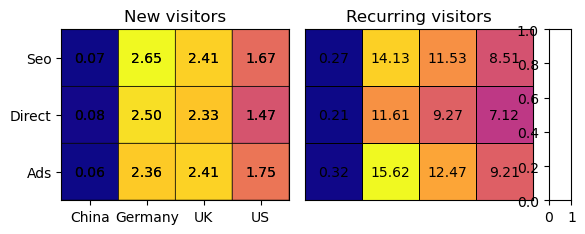

In [12]:
fig1 = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(
    nrows=1, ncols=3,
    width_ratios=[1, 1, 0.1], wspace=0.1,
    figure=fig1,
    left=0.1, bottom=0.2, right=0.95, top=0.77)
axs1 = gs.subplots(sharex=False, sharey=False, squeeze=True)

axs1[0].set_aspect('equal')
axs1[0].pcolor(new_pconv, cmap='plasma', edgecolors='k', lw=0.5)
axs1[0].set_xticks([0.5, 1.5, 2.5, 3.5], countries)
axs1[0].set_yticks([0.5, 1.5, 2.5], sources)
axs1[0].set_title("New visitors")
for (i, j), p in np.ndenumerate(new_pconv):
    axs1[0].text(j+0.5, i+0.5, f'{100*p:.2f}', ha='center', va='center')


axs1[1].set_aspect('equal')
axs1[1].pcolormesh(rec_pconv, cmap='plasma', edgecolors='k', lw=0.5)
axs1[1].tick_params(top=False, labeltop=False,
                  bottom=False, labelbottom=False,
                  left=False, labelleft=False,
                  right=False, labelright=False)
# axs1[1].set_xlim(0, 1.2e5)
axs1[1].set_title("Recurring visitors")
for (i, j), p in np.ndenumerate(new_pconv):
    axs1[0].text(j+0.5, i+0.5, f'{100*p:.2f}', ha='center', va='center')
for (i, j), p in np.ndenumerate(rec_pconv):
    axs1[1].text(j+0.5, i+0.5, f'{100*p:.2f}', ha='center', va='center')


# cb = fig.colorbar(yzprof, cax=ax[2], orientation="horizontal",
#                   ticklocation="top", extend="max", extendfrac=0.03)

plt.show()

Here we show heatmaps of the newsletter subscription probabilility for the categorical features `'source'` and `'country'`, for both new user and recurring users. We can make the following remarks:
- Recurring visitors are 2.5 - 8 times more likely to subscribe to the newsletter.
- Chinese visitors are much less likely to subscribe than others, and US visitors tend to subscribe less than europeans.
- The way by which visitors reached the website has little impact on their eventual subscription.

#### Influence of visitor's age



In [13]:
ages = np.arange(80)
age_data = {
    'counts_rec': np.zeros(80, dtype=int),
    'counts_new': np.zeros(80, dtype=int),
    'pconv_rec': np.zeros(80, dtype=float),
    'std_pconv_rec': np.zeros(80, dtype=float),
    'pconv_new': np.zeros(80, dtype=float),
    'std_pconv_new': np.zeros(80, dtype=float),
}
# new users
inew = df['new_user'] == 1
for i, c in df.loc[inew, 'age'].value_counts().items():
    age_data['counts_new'][i] = c
for i, p in df.loc[inew, ['age', 'converted']].groupby('age').mean()['converted'].items():
    age_data['pconv_new'][i] = p
    age_data['std_pconv_new'][i] = p*(1-p) / np.sqrt(age_data['counts_new'][i])
# recurrent users
irec = df['new_user'] == 0
for i, c in df.loc[irec, 'age'].value_counts().items():
    age_data['counts_rec'][i] = c
for i, p in df.loc[irec, ['age', 'converted']].groupby('age').mean()['converted'].items():
    age_data['pconv_rec'][i] = p
    age_data['std_pconv_rec'][i] = p*(1-p) / np.sqrt(age_data['counts_rec'][i])

In [14]:
from scipy.optimize import curve_fit

def decay_exp(x: np.ndarray,
              A: float,
              tau: float)-> np.ndarray:
    """
    Exponential decay: f(x) = A * exp(- x / tau)
    """
    return A * np.exp(- x / tau)


x = ages[17:]
# new visitors
y_new = age_data['pconv_new'][17:]
yerr_new = age_data['std_pconv_new'][17:]
popt_new, pcov_new = curve_fit(decay_exp, x, y_new, p0=(0.05, 10),
                               sigma=np.where(yerr_new==0., 1., yerr_new))
# recurring visitors
y_rec = age_data['pconv_rec'][17:]
yerr_rec = age_data['std_pconv_rec'][17:]
popt_rec, pcov_rec = curve_fit(decay_exp, x, y_rec, p0=(0.05, 10),
                               sigma=np.where(yerr_rec==0., 1., yerr_rec))

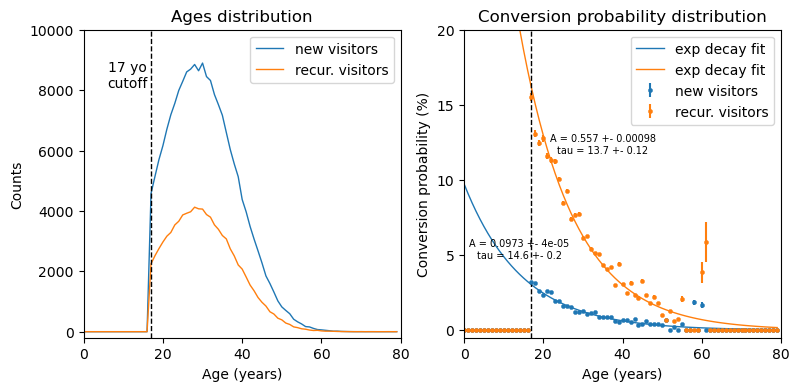

In [15]:
fig2, axs2 = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axs2[0].plot(ages, age_data['counts_new'], color='tab:blue',
             linewidth=1, label='new visitors')
axs2[0].plot(ages, age_data['counts_rec'], color='tab:orange',
             linewidth=1, label='recur. visitors')
axs2[0].axvline(17, color='k', linewidth=1, linestyle='--')
axs2[0].text(11, 8500, '17 yo\ncutoff', ha='center', va='center')
axs2[0].set_xlim(0, 80)
axs2[0].set_ylim(-200, 10000)
axs2[0].set_title("Ages distribution")
axs2[0].set_xlabel('Age (years)')
axs2[0].set_ylabel('Counts')
axs2[0].legend()

axs2[1].errorbar(ages, age_data['pconv_new'], yerr=age_data['std_pconv_new'],
                 color='tab:blue', fmt='o', markersize=3, markeredgewidth=0.3,
                 label='new visitors')
axs2[1].plot(ages, decay_exp(ages, *popt_new),
             linewidth=1, color='tab:blue', label='exp decay fit')
axs2[1].errorbar(ages, age_data['pconv_rec'], yerr=age_data['std_pconv_rec'],
                 color='tab:orange', fmt='o', markersize=3, markeredgewidth=0.3,
                 label='recur. visitors')
axs2[1].plot(ages, decay_exp(ages, *popt_rec),
             linewidth=1, color='tab:orange', label='exp decay fit')
axs2[1].axvline(17, color='k', linewidth=1, linestyle='--')

new_popt_txt = (f'A = {popt_new[0]:.3} +- {pcov_new[0, 0]:.2}\n'
                f'tau = {popt_new[1]:.3} +- {pcov_new[1, 1]:.2}\n')
axs2[1].text(14, 0.05, new_popt_txt, ha='center', va='center', fontsize=7)

rec_popt_txt = (f'A = {popt_rec[0]:.3} +- {pcov_rec[0, 0]:.2}\n'
                f'tau = {popt_rec[1]:.3} +- {pcov_rec[1, 1]:.2}\n')
axs2[1].text(35, 0.12, rec_popt_txt, ha='center', va='center', fontsize=7)

axs2[1].set_xlim(0, 80)
axs2[1].set_ylim(-0.005, 0.20)
axs2[1].set_yticks([0, 0.05, 0.1, 0.15, 0.2], [0, 5, 10, 15, 20])
axs2[1].set_yticks([0, 0.05, 0.1, 0.15, 0.2], minor=True)
axs2[1].set_title("Conversion probability distribution")
axs2[1].set_xlabel('Age (years)')
axs2[1].set_ylabel('Conversion probability (%)')
axs2[1].legend()

plt.show()

Here we show the distribution of ages (left panel) and the conversion probability (right panel)
aggregated by `'source'` and `'country'`, but distinguishing new and recurrent visitors.
- The distribution of ages is the same for the two categories: a truncated gaussian with a cutoff at 17 years old,
  centered at around 28 years old. The probability of having a new visitor is roughly twice that of a recurrent visitor.
- The newsletter subscription probability decays with age. The observed decay fits well with an exponential
  from which we recover very similar decay constants of about 14 years. The multiplicative factor is 5-6 times higher
  for recurrent visitors than for new visitors, and so is the subscription probability both both categories, *independently of age*.

These patterns are extremely regular and again reveal the artificial nature of the data. They would certainly not be occur in a realistic context.

#### Influence of the number of pages visited

We proceed in a similar fashion this time with the quantity `'total_pages_visited'`.

In [16]:
npages = np.arange(30)
page_data = {
    'counts_rec': np.zeros(30, dtype=int),
    'counts_new': np.zeros(30, dtype=int),
    'pconv_rec': np.zeros(30, dtype=float),
    'std_pconv_rec': np.zeros(30, dtype=float),
    'pconv_new': np.zeros(30, dtype=float),
    'std_pconv_new': np.zeros(30, dtype=float),
}

# new users
inew = df['new_user'] == 1
for i, c in df.loc[inew, 'total_pages_visited'].value_counts().items():
    page_data['counts_new'][i] = c
for i, p in df.loc[inew, ['total_pages_visited', 'converted']].groupby('total_pages_visited').mean()['converted'].items():
    page_data['pconv_new'][i] = p
    page_data['std_pconv_new'][i] = p*(1-p) / np.sqrt(page_data['counts_new'][i])
# recurrent users
irec = df['new_user'] == 0
for i, c in df.loc[irec, 'total_pages_visited'].value_counts().items():
    page_data['counts_rec'][i] = c
for i, p in df.loc[irec, ['total_pages_visited', 'converted']].groupby('total_pages_visited').mean()['converted'].items():
    page_data['pconv_rec'][i] = p
    page_data['std_pconv_rec'][i] = p*(1-p) / np.sqrt(page_data['counts_rec'][i])

In [17]:
def sigmoid(x: np.ndarray,
            x0: float,
            a: float)-> np.ndarray:
    """
    Exponential decay: f(x) = 1 / (1 + exp(- a * (x - x0)))
    """
    return 1 / (1 + np.exp(- a * (x - x0)))


x = npages
# new visitors
y_new = page_data['pconv_new']
yerr_new = page_data['std_pconv_new']
popt_new, pcov_new = curve_fit(sigmoid, x, y_new, p0=(15, 1),
                               sigma=np.where(yerr_new==0., 1., yerr_new))
# recurring visitors
y_rec = page_data['pconv_rec']
yerr_rec = page_data['std_pconv_rec']
popt_rec, pcov_rec = curve_fit(sigmoid, x, y_rec, p0=(15, 1),
                               sigma=np.where(yerr_rec==0., 1., yerr_rec))

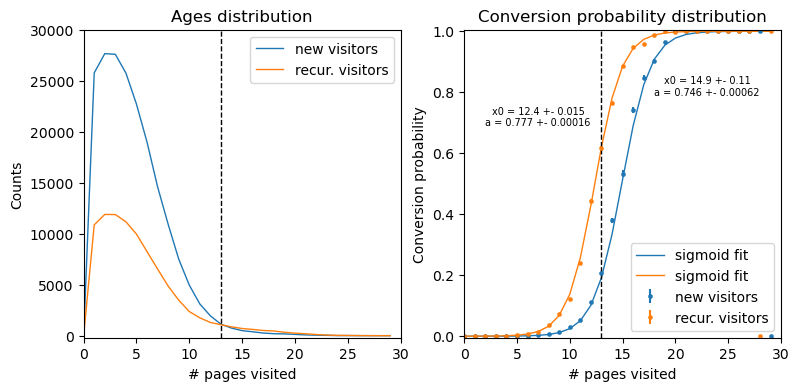

In [18]:
fig3, axs3 = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axs3[0].plot(npages, page_data['counts_new'], color='tab:blue',
             linewidth=1, label='new visitors')
axs3[0].plot(npages, page_data['counts_rec'], color='tab:orange',
             linewidth=1, label='recur. visitors')
axs3[0].axvline(13, color='k', linewidth=1, linestyle='--')
# axs3[0].text(11, 8500, '17 yo\ncutoff', ha='center', va='center')
axs3[0].set_xlim(0, 30)
axs3[0].set_ylim(-200, 30000)
axs3[0].set_title("Ages distribution")
axs3[0].set_xlabel('# pages visited')
axs3[0].set_ylabel('Counts')
axs3[0].legend()

axs3[1].errorbar(npages, page_data['pconv_new'], yerr=page_data['std_pconv_new'],
                 color='tab:blue', fmt='o', markersize=3, markeredgewidth=0.3,
                 label='new visitors')
axs3[1].plot(npages, sigmoid(npages, *popt_new),
              linewidth=1, color='tab:blue', label='sigmoid fit')
axs3[1].errorbar(npages, page_data['pconv_rec'], yerr=page_data['std_pconv_rec'],
                 color='tab:orange', fmt='o', markersize=3, markeredgewidth=0.3,
                 label='recur. visitors')
axs3[1].plot(npages, sigmoid(npages, *popt_rec),
             linewidth=1, color='tab:orange', label='sigmoid fit')
axs3[1].axvline(13, color='k', linewidth=1, linestyle='--')

new_popt_txt = (f'x0 = {popt_new[0]:.3} +- {pcov_new[0, 0]:.2}\n'
                f'a = {popt_new[1]:.3} +- {pcov_new[1, 1]:.2}\n')
axs3[1].text(23, 0.8, new_popt_txt, ha='center', va='center', fontsize=7)

rec_popt_txt = (f'x0 = {popt_rec[0]:.3} +- {pcov_rec[0, 0]:.2}\n'
                f'a = {popt_rec[1]:.3} +- {pcov_rec[1, 1]:.2}\n')
axs3[1].text(7, 0.7, rec_popt_txt, ha='center', va='center', fontsize=7)

axs3[1].set_xlim(0, 30)
axs3[1].set_ylim(-0.005, 1.005)
# axs3[1].set_yticks([0, 0.05, 0.1, 0.15, 0.2], [0, 5, 10, 15, 20])
# axs3[1].set_yticks([0, 0.05, 0.1, 0.15, 0.2], minor=True)
axs3[1].set_title("Conversion probability distribution")
axs3[1].set_xlabel('# pages visited')
axs3[1].set_ylabel('Conversion probability')
axs3[1].legend()

plt.show()

Here we show the distribution of number of pages visited (left panel) and the corresponding conversion probability (right panel) built the same way as in the previous figure.
- Although we still have a factor ~2 between the total counts, we remark that website visits with more than 13 pages visited are mostly done by recurrent visitors. Accounting for the factor 2, this makes it more than twice likely that a > 13 pages visit is done by a recurrent visitor.
- The two distributions are thus not proportional. They actually look like [inverse-gamma distributions](https://en.wikipedia.org/wiki/Inverse-gamma_distribution).
- The newsletter subscription probability looks like a sigmoid for both new and recurring visitors. The inflection points are shifted, and looking at the 13 pages-visits threshold, we see that here the conversion probability is thrice for recurring users than for new users.
- Sigmoid fits with the slope and inflection point as parameters is also shown on the right panel. The slopes are roughly the same, the difference being the inflection point: 12.5 pages for recurring visitors vs 15 pages for new visitors.
- Finally, we note two outlier events on the right panel. ~30 pages visits with no subscription. We might consider removing these observations for training later on.

We again stress that such regularity is unlikely in any realistic context.

#### Combined influence of age and number of pages visited